<a href="https://colab.research.google.com/github/KimyYoungWook/DataScience/blob/main/practice/%5Bsklearn%5D_Titanic_Classification_Ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문제 정의 : 타이타닉 생존자 예측 데이터셋 사용하여 유무를 예측하는 이진분류 사망:0 생존:1

라이브러리 불러오기

In [ ]:
#Libraries for reading and handling the data
import numpy as np
import pandas as pd
import re

#Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin

#Libraries for creating ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Libraries for Analysing the ML model
from sklearn import metrics

[step1] 데이터 준비하기

In [ ]:
train_path = 'train.csv'

target = 'Survived'

index = 'PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic = pd.read_csv(train_path, index_col= index, dtype=dtypes)

[step2] 데이터 살펴보기

In [ ]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


데이터 시각화

In [ ]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

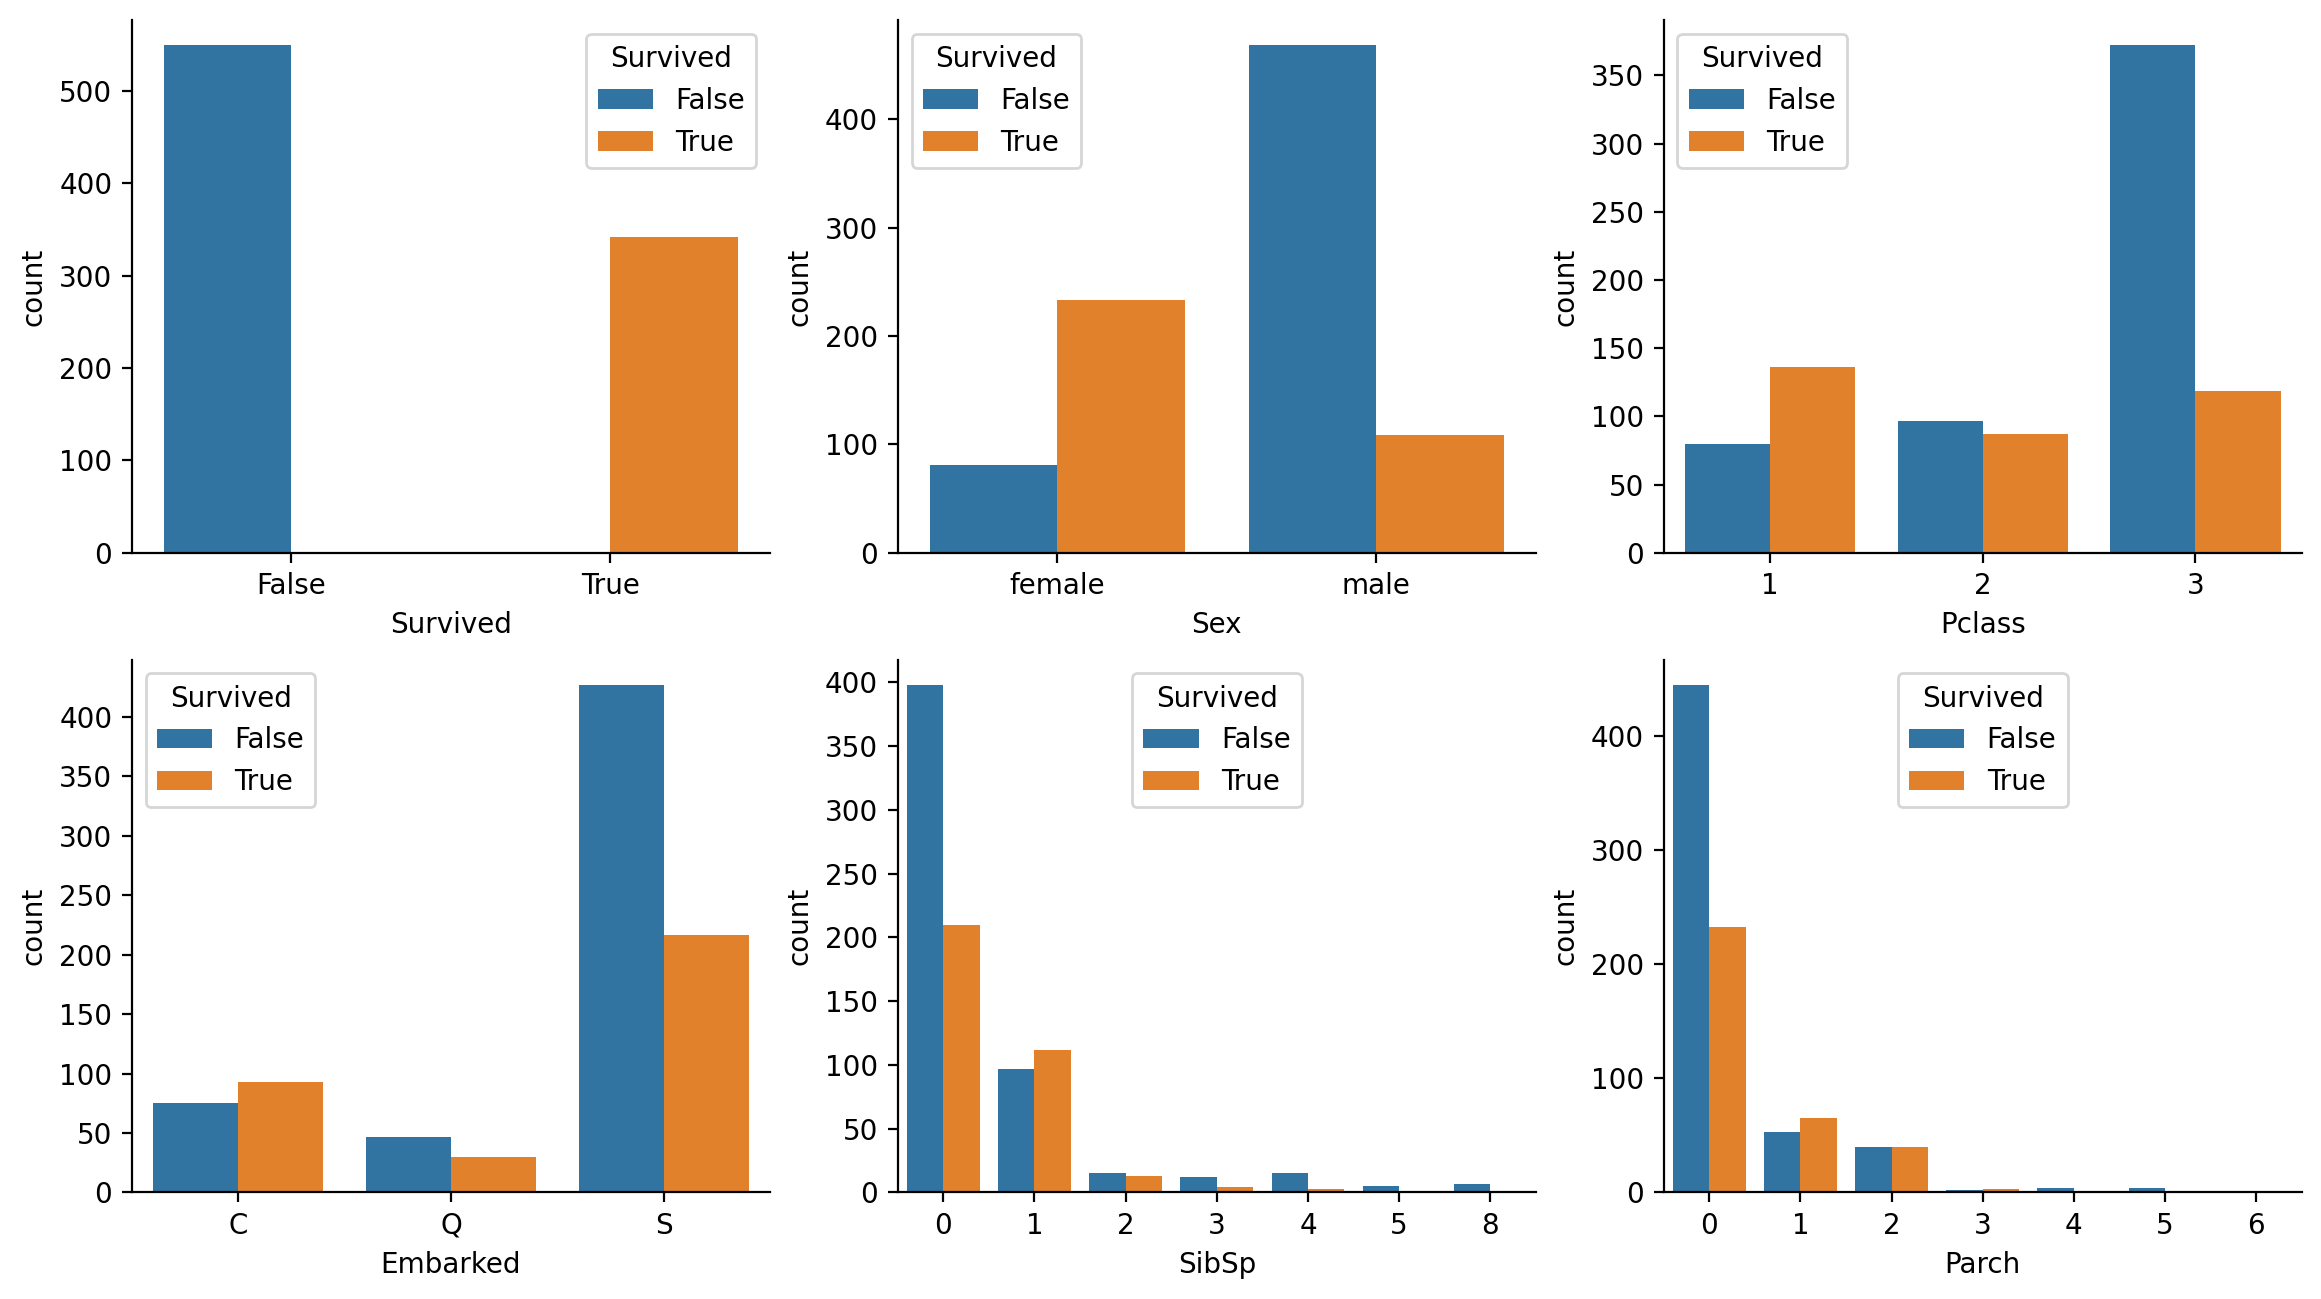

In [ ]:
attributes =['Survived', 'Sex','Pclass','Embarked','SibSp','Parch']
plt.figure(figsize=(14,12),dpi=200)
for i ,feature in enumerate(attributes) :
  plt.subplot(3,3,i+1)
  sns.countplot(x=feature,data=titanic,hue='Survived')

sns.despine()

[step3] 데이터 전처리

In [ ]:
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [ ]:
def get_title(name) :
  return re.split(',|\.', name)[1].strip()

In [ ]:
# 이름에서 호칭을 추출 Mr,Miss,Dr...
titanic['title']=titanic['Name'].apply(get_title)

In [ ]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [ ]:
#호칭이 생존에 과연 영향을 끼치는지 확인을 위해서 집계함ㅅ수 -> 카운트. 평균
titles = titanic.groupby('title').agg({'Survived' : ['count','mean']})

In [ ]:
#Survived 컬럼 레이어 정리
titles.columns =titles.columns.droplevel()

In [ ]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean',ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [ ]:
# 호칭 추출이 되지 않은 title 값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])
titanic['title'] =titanic['title'].replace(uncommon_titles,'other')

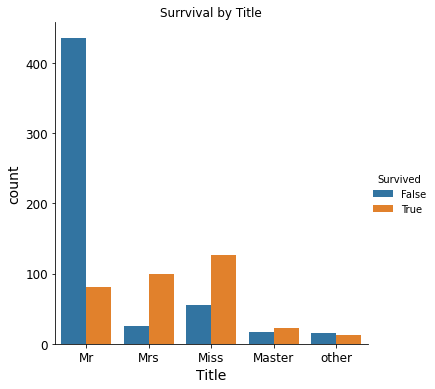

In [ ]:
sns.catplot(x='title',kind='count',hue='Survived',data=titanic)
plt.tick_params(labelsize=12)
plt.ylabel('count',fontsize=14)
plt.xlabel('Title',fontsize=14)
plt.title('Surrvival by Title')
plt.show()

In [ ]:
# 가족 사이즈(fam_size) ->
# Sibsp(동승한 자매 or 배우자) + parch(동승한 부모 or 자식수
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

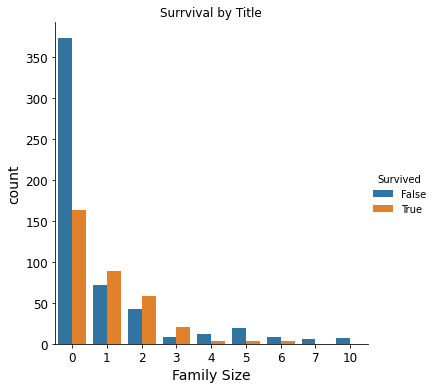

In [ ]:
sns.catplot(x='fam_size',kind='count',hue='Survived',data=titanic)
plt.tick_params(labelsize=12)
plt.ylabel('count',fontsize=14)
plt.xlabel('Family Size',fontsize=14)
plt.title('Surrvival by Title')
plt.show()

ML을 위한 전처리

In [ ]:
# 필요 없는 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [ ]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [ ]:
# 여성을 1로 남성을 0으로 처리
tmp=[]
for each in titanic['Sex'] :
  if each == 'female':
    tmp.append(1)
  elif each == 'male' :
    tmp.append(0)
  else:
    tmp.append(np.nan)

titanic['Sex'] =tmp

In [ ]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


데이터 형변환 및 결측치 처리

In [ ]:
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

In [ ]:
#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


데이터 분리하기 X(문제집),y(정답)

In [ ]:
titanic_labels =titanic['Survived'].copy()
titanic = titanic.drop('Survived',axis=1)

In [ ]:
X_train,X_test, y_train,y_test = train_test_split(titanic,titanic_labels,
                                                  train_size=0.8, # test_size 0.2
                                                  # 데이터량이 적어 8:2로 나눔
                                                  )

[setp5] 머신러닝 모델 구축 - 1) LogisticRegression

In [ ]:
log_reg=LogisticRegression().fit(X_train,y_train)

In [ ]:
# 정확도 확인
print('Train data Score: ',log_reg.score(X_train,y_train))
print('Test data Score: ',log_reg.score(X_test,y_test))

Train data Score:  0.8108581436077058
Test data Score:  0.8111888111888111


머신러닝 모델 구축 -2) Decision Tree

In [ ]:
tree =DecisionTreeClassifier(max_depth=5,
                             min_samples_leaf=20,
                             min_samples_split=40).fit(X_train,y_train)

In [ ]:
# 정확도 확인
print('Train data Score: ',tree.score(X_train,y_train))
print('Test data Score: ',tree.score(X_test,y_test))

Train data Score:  0.8283712784588442
Test data Score:  0.7902097902097902


머신러닝 모델 구축 -3) GradientBoostingClassifier

In [ ]:
boost =GradientBoostingClassifier (max_depth=3,
                                   learning_rate=0.05).fit(X_train,y_train)

In [ ]:
# 정확도 확인
print('Train data Score: ',boost.score(X_train,y_train))
print('Test data Score: ',boost.score(X_test,y_test))

Train data Score:  0.8984238178633975
Test data Score:  0.8041958041958042


머신러닝 모델 구축 -4)RandomForestClassifier

In [ ]:
random = RandomForestClassifier(n_estimators=300,
                                random_state=0).fit(X_train,y_train)

In [ ]:
# 정확도 확인
print('Train accuracy Score: ',random.score(X_train,y_train))
print('Test accuracy Score: ',random.score(X_test,y_test))

Train accuracy Score:  0.9929947460595446
Test accuracy Score:  0.7972027972027972


[step6] 성능평가 -ROC커브

In [ ]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

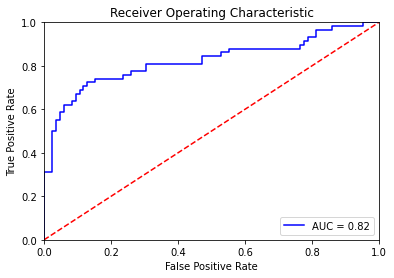

In [ ]:
#LogisticRegression
plot_auc_roc(log_reg)

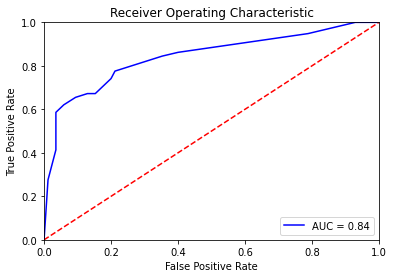

In [ ]:
#Decision Tree
plot_auc_roc(tree)

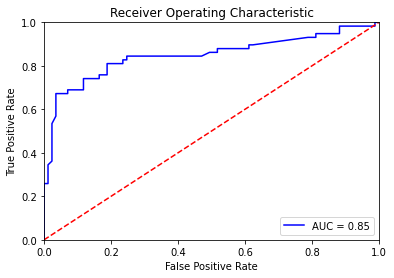

In [ ]:
#GradientBoostingClassifier
plot_auc_roc(boost)

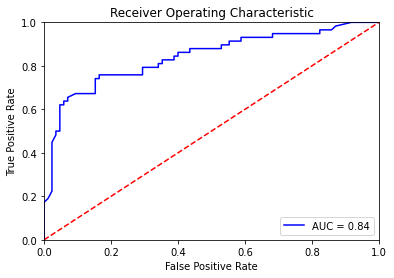

In [ ]:
#RandomForestClassifier
plot_auc_roc(random)

In [ ]:
#LogisticRegression 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report =metrics.classification_report(y_test,lg_y_hat)
print("LogisticRegression 평가지표")
print(lg_report)
print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat))

LogisticRegression 평가지표
              precision    recall  f1-score   support

       False       0.82      0.87      0.85        85
        True       0.79      0.72      0.76        58

    accuracy                           0.81       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143

accuracy 0.8111888111888111
precision 0.7924528301886793
recall 0.7241379310344828
f1 0.7567567567567567


In [ ]:
#Decision Tree 평가 지표
tr_y_hat = tree.predict(X_test)
tr_report =metrics.classification_report(y_test,tr_y_hat)
print("Decision Tree 평가지표")
print(tr_report)
print('accuracy', metrics.accuracy_score(y_test,tr_y_hat) )
print('precision', metrics.precision_score(y_test,tr_y_hat) )
print('recall', metrics.recall_score(y_test,tr_y_hat) )
print('f1', metrics.f1_score(y_test,tr_y_hat) )


Decision Tree 평가지표
              precision    recall  f1-score   support

       False       0.80      0.87      0.83        85
        True       0.78      0.67      0.72        58

    accuracy                           0.79       143
   macro avg       0.79      0.77      0.78       143
weighted avg       0.79      0.79      0.79       143

accuracy 0.7902097902097902
precision 0.78
recall 0.6724137931034483
f1 0.7222222222222223


In [ ]:
#GradientBoostingClassifier평가 지표
bs_y_hat = boost.predict(X_test)
bs_report =metrics.classification_report(y_test,bs_y_hat)
print("GradientBoostingClassifier 평가지표")
print(bs_report)
print('accuracy', metrics.accuracy_score(y_test,bs_y_hat) )
print('precision', metrics.precision_score(y_test,bs_y_hat) )
print('recall', metrics.recall_score(y_test,bs_y_hat) )
print('f1', metrics.f1_score(y_test,bs_y_hat))


GradientBoostingClassifier 평가지표
              precision    recall  f1-score   support

       False       0.81      0.88      0.84        85
        True       0.80      0.69      0.74        58

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

accuracy 0.8041958041958042
precision 0.8
recall 0.6896551724137931
f1 0.7407407407407408


In [ ]:
#RandomForestClassifier평가 지표
rd_y_hat = random.predict(X_test)
bs_report =metrics.classification_report(y_test,rd_y_hat)
print("GradientBoostingClassifier 평가지표")
print(bs_report)
print('accuracy', metrics.accuracy_score(y_test,rd_y_hat) )
print('precision', metrics.precision_score(y_test,rd_y_hat) )
print('recall', metrics.recall_score(y_test,rd_y_hat) )
print('f1', metrics.f1_score(y_test,rd_y_hat))

GradientBoostingClassifier 평가지표
              precision    recall  f1-score   support

       False       0.83      0.82      0.83        85
        True       0.75      0.76      0.75        58

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143

accuracy 0.7972027972027972
precision 0.7457627118644068
recall 0.7586206896551724
f1 0.752136752136752


In [ ]:
precision_list = []
recall_list = []

precision_list.append(metrics.precision_score(y_test,lg_y_hat))
recall_list.append(metrics.recall_score(y_test,lg_y_hat))

precision_list.append(metrics.precision_score(y_test,tr_y_hat))
recall_list.append(metrics.recall_score(y_test,tr_y_hat))

precision_list.append(metrics.precision_score(y_test,bs_y_hat))
recall_list.append(metrics.recall_score(y_test,bs_y_hat))

precision_list.append(metrics.precision_score(y_test,rd_y_hat))
recall_list.append(metrics.recall_score(y_test,rd_y_hat))

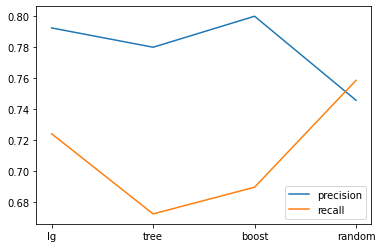

In [ ]:
plt.plot(['lg','tree','boost','random'],precision_list,label='precision')
plt.plot(['lg','tree','boost','random'],recall_list,label='recall')
plt.legend()
plt.show()